# Prova Final - Carreira

Parabéns! Após um bem-sucedido mestrado em métodos matemáticos, vocês foram escolhidos como quants do fundo Short Term INtelliGence (STING). O fundo está no Brasil, funding e benchmark são o CDI; as vols são offshore mas pode usar como se fosse onshore.

De posse de uma série histórica de preços, responda as seguintes questões:

In [425]:
from __future__ import division
from datetime import datetime  
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.cm as cm
%matplotlib inline
plt.style.use('ggplot')

In [249]:
# Carrega os dados do arquivo
tb_USDBRL = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "A:E")
tb_PTAX = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "G:H")
tb_IBOV = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "J:M")
tb_DIJAN21 = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "O:S")
tb_CDI = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "U:V")
tb_CDSBRAZIL = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "X:AB")
tb_VOLATM1M = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "AD:AH")
tb_VOLATM3M = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "AJ:AN")
tb_VOLATM1Y = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "AP:AT")
tb_SWPPREDI1M = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "AV:AZ")
tb_SWPPREDI3M = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "BB:BF")
tb_SWPPREDI1Y = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "BH:BL")
tb_FWD1M = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "BN:BR")
tb_FWD3M = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "BT:BX")
tb_FWD1Y = pd.read_excel('BBergValues.xlsx', header = 1, index_col = 0, parse_cols = "BZ:CD")

------------------------------

### Questão 1

Como estimar o risco dos portfolios do fundo a partir das séries de preços? Aponte as diferenças entre como estimar o risco entre os diferentes tipos de séries. Assuma que esse cálculo está sendo feito em 31-Mar-2016.

_O risco é calculado basicamente de acordo com as volatilidades das séries históricas, mas especificamente dos retornos de cadas ativo. Variações em séries de preço não devem ser observadas da mesma maneira que variações em séries de taxas, por exemplo. Aglumas conversões fazem-se necessárias. Além disso, é necessário modelar o cálculo das volatilidades (EWMA, GARCH, etc) e o mais importante: o modelo para o cálculo do risco do portfolio._

_Dentre os modelos mais comuns para o cálculo de risco podemos citar, por exemplo, o modelo estatístico (paramétrico), o modelo de simulação Monte Carlo e o modelo de simulação histórica. Cada modelo tem suas particularidades e é necessário ficar atento a elas._

_No modelo paramétrico, é necessário calcular a matriz de correlação entre todos os ativos do portfolio e admitir algumas premissas que já sabemos que não condizem com a realidade. Assume-se, por exemplo, que a distribuição dos retornos dos ativos é normal, o que nem sempre acontece. Este foi o modelo inicialmente adotado pelo mercado que, ao entender suas fragilidades, aos poucos foi migrando para modelos mais robustos, como os que se seguem. Apesar de ser um modelo didático para a análise de risco, dada sua simplicidade, hoje é pouco utilizado._

_No modelo de simulação Monte Carlo, o desafio é modelar cada tipo de ativo de acordo com suas características. Itens como a estacionariedade são essenciais para a definição dos modelos. Uma vez determinados bons modelos para cada um dos ativos presente no portfolio, podemos simular milhares de cenários e marcar a mercado cada produto. Devido a este grande número de simulações, este modelo demanda grande poder computacional, o que requer programação em linguagens de alto nível com código performático. Após as simualações, é necessário escolher o intervalo de confiança desejado e finalmente calcular a perda máxima esperada._

_Diferente do anterior, no modelo de simulação histórica, as decisões são tomadas de acordo com o comportamento histórico dos ativos. No contexto deste exercício, seria o modelo que eu utizaria, dada a posse das séries históricas dos ativos e a menor necessidade de poder computacional, quando comparado ao Monte Carlo. Para utilizar este, é preciso entender como os dados são exibidos e tratá-los da maneira correta. Usar retornos para as séries de preço e converter em PU as variações de taxa são práticas comuns. Após a adequação de cada série, são definidos os cenários (geralmente baseados em projeções econômicas) e estes são simulados nas séries históricas de retorno. Similar ao modelo anterior, após simular todos os cenários descritos, definimos um intervalo de confiança (usualmente entre 95% e 99%) e calculamos a perda máxima esperada._

------------------------------

### Questão 2

Um trader olhou o gráfico abaixo e pensou em uma estratégia.

!['Print BBG'](BBG.jpg)

(a) Qual a estratégia que você acha que ele pensou?

(b) Faz sentido? Qual a proporção dos ativos? Ela é fixa?

(c) Se ele tivesse entrado no trade em 13-Abr-2016, qual teria sido o máximo drawdown (perda) dele no período entre 13-Abr-2016 e 22-Jun-2016? Assuma notional de BRL 1MM.

(d) A estimativa de risco que você teria feito teria estimado corretamente esse resultado?

(e) Acrescente Ibovespa como uma estratégia (não esqueça do funding!); você faria algum novo trade?

_(a) Observando este momento no gráfico, a estratégia óbvia é realizar um "pair trading" - compra o ativo barato e vende o(s) caro(s), dada a tendência de retorno à convergência dos mesmos._

_(b) Na teoria faz sentido: notadamente estes ativos tem uma forte correlação entre si e, neste ponto, o ODF21 "descolou" dos demais. Na prática não foi bem assim: a trajetória do USDBRL apresentou um comportamento inesperado, o que levou a uma perda no fim do trade (mais detalhes abaixo).
As proporções dos ativos são dinâmicas, e mudam de acordo com a variação de cada um, dado que estão em escalas diferentes. Neste exemplo, eu deixaria o CDS de lado (por desconhecer a liquidez do mercado), e compraria ODF21 e venderia USDBRL. Para o cálculo da proporção entre os ativos, foi observada uma janela onde os ativos mativeram-se bem correlacionados (2/jan a 15/mar). Observando este período, chegamos numa proporção de 2.943,47 dólares para cada basis point de variação na pré._

_(c) Admitindo a compra de ODF21 e a venda de USDBRL na porporção citada acima, a perda máxima do portfolio foi de 12.475,90. _

_(d) Provavelmente não, pois o comportamento analisado previamente entre os ativos não era o mesmo, e os ativos apresentaram comportamentos inesperados no tempo que se seguiu._

In [250]:
# variáveis para o cálculo da proporção dos ativos
dt_inic='2016-01-02'
dt_fim='2016-03-15'
USDBRL=tb_USDBRL.loc[dt_inic:dt_fim,'PX_LAST']
JAN21=tb_DIJAN21.loc[dt_inic:dt_fim,'PX_LAST']

# calcula a proporção entre
var_USDBRL=np.abs(USDBRL[-1]/USDBRL[0]-1)
var_JAN21=np.abs((JAN21[-1]-JAN21[0])*100)
prop=var_JAN21/var_USDBRL
not_USDBRL=1000000
not_JAN21=not_USDBRL/prop

# variáveis para o cálculo da evolução do portfolio
dt='2016-04-13'
USDBRL=tb_USDBRL.loc[dt:,'PX_LAST']
JAN21=tb_DIJAN21.loc[dt:,'PX_LAST']

# variávies para resultado
res_USDBRL=0
res_JAN21=0
res_TOTAL=0

# monta a tabela de resultados
colunas=['data','USDBRL','JAN21','res USDBRL','res JAN 21','res TOTAL']
tab=pd.DataFrame(columns=colunas)

for i in range(len(USDBRL)):
    
    # armazen as variáveis atuais
    dt_atual=USDBRL.index[i]

    # calcula os resultados
    if dt_atual.strftime('%Y-%m-%d')!=dt:
        res_USDBRL=-not_USDBRL*(1-USDBRL[i]/USDBRL[0])
        res_JAN21=not_JAN21*(JAN21[0]-JAN21[i])*100
        res_TOTAL=res_USDBRL+res_JAN21
    
    # insere no grid
    tab.loc[i]=[dt_atual,USDBRL[i],JAN21[i],res_USDBRL,res_JAN21,res_TOTAL]
    
print('Proporção: ' + repr(round(prop,2)))
print('Maior perda = ' + repr(round(min(tab['res TOTAL']),2)))
tab  

Proporção: 2943.4699999999998
Maior perda = -12475.9


,data,USDBRL,JAN21,res USDBRL,res JAN 21,res TOTAL
0,2016-04-13,3.4984,13.14,0.000000,0.000000,0.000000
1,2016-04-14,3.4834,13.04,-4287.674365,3397.346494,-890.327872
2,2016-04-15,3.5317,13.04,9518.637091,3397.346494,12915.983585
3,2016-04-18,3.6153,12.86,33415.275555,9512.570182,42927.845737
4,2016-04-19,3.5304,12.90,9147.038646,8153.631585,17300.670231
5,2016-04-20,3.5292,12.88,8804.024697,8833.100883,17637.125580
6,2016-04-21,3.5292,12.88,8804.024697,8833.100883,17637.125580
7,2016-04-22,3.5646,12.90,18922.936199,8153.631585,27076.567784
8,2016-04-25,3.5577,12.75,16950.605991,13249.651325,30200.257316
9,2016-04-26,3.5297,12.76,8946.947176,12909.916676,21856.863851


---------------

### Questão 3

Em 30-Jun-2015 vários traders compraram opções de compra de USD (venda de BRL) ATMF para diferentes prazos. Use os dados anexos, interpolação linear para spot e forwards, e a interpolação adequada para vols ATMF (vol forward constante, variância efetiva é a soma das variâncias efetivas) para estimar os resultados finais e perdas máximas de cada um dos traders.

_O algoritmo "portfolio" abaixo serve para todas as questões envolvendo portfolios com opções, com ou sem hedge e com rebalanceamento diário ou semanal (questões 3, 5, 6 e 7). Algumas informações sobre ele:_

* _Interpolação linear para spot e fwds_
* _Interpolação para vol:_

!['Vol'](Vol.jpg)

* _Cálculo do prêmio utilizando a fórmula de Black (com fwd)._
* _Hedge feito com um fwd por dia. A cada rebalanceamento é liquidado o fwd anterior e aberto um novo de maneira simplificada: somado apenas o ajuste trazido a VP pela pré ((1+r)^(prz/252), calculado sempre utilizando os preços de fechamento._
* _Caixa sempre accruado em 1 dia de CDI a cada iteração, independente se positivo ou negativo ((1+CDI)^(1/252))._
* _Valor do portfolio sempre atualizado com o caixa atual + o MtM da opção._
* _Fixing para liquidação de opções = PTAX_
* _Verificação de stoploss no fechamento do dia. Uma vez atingido, o portfolio é desmontado na abertura do dia seguinte, utilizando os preços de abertura._
* _O rebalanceamento semanal é feito sempre no mesmo dia da semana do início da operação._
* _Maior perda é apresentada sempre em módulo._  
  
_Resultados após o código._

**Para observar a evolução dos portfolios, executar o código na ÚLTIMA célula.**

In [251]:
# cálculo do prêmio - fórmula de Black (utilizando fwd)
def bsv(tipo,fwd,K,r,vol,t,hedge=False):
    
    if tipo=='c':
        phi=1
    else:
        phi=-1
    
    efv=t*(vol**2)
    d1=(np.log(fwd/K)+(efv/2))/(np.sqrt(efv))
    d2=(np.log(fwd/K)-(efv/2))/(np.sqrt(efv))
        
    Nd1=st.norm.cdf(phi*d1)
    Nd2=st.norm.cdf(phi*d2)
        
    if hedge:
        de=phi*Nd1
    else:
        de=0
    
    pr=phi*np.exp(-r*t)*(fwd*Nd1-K*Nd2)

    return [pr,de]

In [252]:
# calcula o payoff de uma opção (call ou put)
def PayoffOpc(tipo,S,K):
    
    if tipo=='c':
        phi=1
    else:
        phi=-1
    
    return max([phi*(S-K), 0])

In [253]:
def interp_vol(dt_atual, prz):
    
    # armazena as vols e prazos de referência
    prz1=21
    vol1=tb_VOLATM1M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
    prz2=63
    vol2=tb_VOLATM3M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
    prz3=252
    vol3=tb_VOLATM1Y.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
    
    # interpola
    if prz<=prz1:
        vol=vol1
    elif prz<=prz2:
        prz_ma=prz2
        prz_me=prz1
        vol_ma=vol2
        vol_me=vol1
        vol=np.sqrt(((1/(prz_ma-prz_me))*((vol_ma**2)*prz_ma*(prz-prz_me)+(vol_me**2)*prz_me*(prz_ma-prz)))/prz)
    elif prz<=prz3:
        prz_ma=prz3
        prz_me=prz2
        vol_ma=vol3
        vol_me=vol2
        vol=np.sqrt(((1/(prz_ma-prz_me))*((vol_ma**2)*prz_ma*(prz-prz_me)+(vol_me**2)*prz_me*(prz_ma-prz)))/prz)
    else:
        vol=vol3
    
    return(vol)
    

In [254]:
def portfolio(dt,phi,tipo,K,T,hedge=False,stoploss=0,verif='diaria'):
    
    # armazena data inicial e dia da semana
    dt_atual=datetime.strptime(dt,'%Y-%m-%d')
    dow=dt_atual.weekday()
    
    # inicialização de variáveis
    flag_stoploss=False
    prz=T
    fwd_ant=0
    de_ant=0.5
    
    # cria a tabela de evolução do portfolio
    colunas=['data','prazo','K','spot','fwd','ptax','r','vol','cdi','premio','delta','caixa','port']
    tab=pd.DataFrame(columns=colunas)
    
    while prz>-1:                   
        if dt_atual.strftime('%Y-%m-%d') in tb_CDI.index:
            
            # interpolação do fwd
            spot=tb_USDBRL.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']
            fwd1=tb_FWD1M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']
            fwd2=tb_FWD3M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']
            fwd3=tb_FWD1Y.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']
            y=[spot,fwd1,fwd2,fwd3]
            x=[0,21,63,252]
            fwd=np.interp(prz,x,y)

            # interpolação da vol
            vol=interp_vol(dt_atual, prz)
            
            # interpolação da tx juros
            cdi=tb_CDI.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
            r1=tb_SWPPREDI1M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
            r2=tb_SWPPREDI3M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
            r3=tb_SWPPREDI1Y.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
            y=[cdi,r1,r2,r3]
            x=[0,21,63,252]
            r=np.interp(prz,x,y)
            
            # armazena CDI do dia
            cdi=tb_CDI.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
            
            # armazena PTAX do dia
            if prz==T:
                ptax='-'
            else:
                ptax=tb_PTAX.loc[dt_ant.strftime('%Y-%m-%d'),'PX_ASK']

            # calcula prêmio e delta
            [pr,de]=bsv(tipo,fwd,K,r,vol,prz/252,hedge)
            
            # verifica se há rebalanceamento
            if ((hedge==True) and (verif=='semanal') and (prz!=T) and (dt_atual.weekday()!=dow)):
                de=0    
                rebal=False
            else:
                rebal=True
            
            # no instanta inicial, o portfolio vale zero e o caixa é o prêmio BS da opção
            if prz==T:
                caixa=-phi*pr
                port=caixa+phi*pr
                fwd_ant=fwd
                de_ant=de
                
            # se estamos no vencimento ou o stoploss foi atingido
            elif prz==0 or flag_stoploss:
                
                # carrega o caixa por 1 dia de CDI
                caixa=caixa*((1+cdi)**(1/252))
                
                # verifica se o stoploss foi atingido no fechamento do dia anterior
                if flag_stoploss:
                    
                    # se o stoploss foi atingido, reverte a opção utilizando o fwd de abertura
                    spot=tb_USDBRL.loc[dt_atual.strftime('%Y-%m-%d'),'PX_OPEN']
                    fwd1=tb_FWD1M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_OPEN']
                    fwd2=tb_FWD3M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_OPEN']
                    fwd3=tb_FWD1Y.loc[dt_atual.strftime('%Y-%m-%d'),'PX_OPEN']
                    y=[spot,fwd1,fwd2,fwd3]
                    x=[0,21,63,252]
                    fwd=np.interp(prz,x,y)
                    [pr,de]=bsv(tipo,fwd,K,r,vol,prz/252,hedge)
                    payoff=phi*pr
                                       
                else:
                    
                    # se chegamos no vencimento, calcula o payoff da opção pela PTAX
                    payoff=phi*PayoffOpc(tipo,ptax,K)
                
                # calcula o ajuste do fwd - se o stoploss foi atingido, utiliza o fwd de abertura
                ajuste=-phi*(fwd-fwd_ant)*de_ant/((1+r)**(prz/252))
                
                # atualiza com o ajuste do fwd e o payoff da opção
                caixa=caixa+ajuste+payoff
                
                # atualiza o valor do portfolio
                port=caixa
                
                # se o stoploss foi atingido no fechamento anterior, encerra
                if flag_stoploss:
                    tab.loc[T-prz]=[dt_atual,prz,K,spot,fwd,ptax,r,vol,cdi,pr,de,caixa,port]
                    break
                
            else:
                # carrega o caixa 1 dia de CDI
                caixa=caixa*((1+cdi)**(1/252))
                
                # se há rebalanceamento, calcula o ajuste do fwd (pelo fwd anterior) e incrementa no caixa
                if rebal:
                    ajuste=-phi*(fwd-fwd_ant)*de_ant/((1+r)**(prz/252))
                    caixa=caixa+ajuste
                    de_ant=de
                    fwd_ant=fwd
                
                # atualiza o valor do portifolio
                port=caixa+phi*pr
                
                # verifica se o stoploss foi atingido - se sim, seta o flag e encerra a operação na iteração seguinte
                if (stoploss!=0) and (port<stoploss):
                    flag_stoploss=True
            
            # adiciona linha na tabela
            tab.loc[T-prz]=[dt_atual,prz,K,spot,fwd,ptax,r,vol,cdi,pr,de,caixa,port]
            
            # atualiza o prazo
            prz=prz-1
            dt_ant=dt_atual
        
        # atualiza data atual
        dt_atual=dt_atual+timedelta(days=1)
        
    return tab

In [255]:
# cria dicionário para armazenar todos os portfolios calculados
portifolios={}

In [256]:
# cria a tabela para os resultados
colunas=['exercícios','descrição','resultado','maior perda']
resultados3=pd.DataFrame(columns=colunas)

# variáveis comuns a todos (data de início, lado [compra=1 ou venda=-1] e tipo [call ou put], stoploss=não, verif=diária)
dt='2015-06-30'
phi=1
tipo='c'
stoploss=0
verif='diaria'

for trader in range(6):
       
    # descrição do trader
    if trader==0: 
        ex='3a'
        desc='compra opc 1M'
    elif trader==1:
        ex='3b'
        desc='compra opc 1M + delta hedge diário'
    elif trader==2: 
        ex='3c'
        desc='compra opc 3M'
    elif trader==3:
        ex='3d'
        desc='compra opc 3M + delta hedge diário'
    elif trader==4: 
        ex='3e'
        desc='compra opc 1Y'
    elif trader==5:
        ex='3f'
        desc='compra opc 1Y + delta hedge diário'
    
    # determina o prazo da opção
    if trader<2:
        T=21
        K=tb_FWD1M.loc[dt,'PX_LAST']
    elif trader<4:
        T=63
        K=tb_FWD3M.loc[dt,'PX_LAST']
    else:
        T=252
        K=tb_FWD1Y.loc[dt,'PX_LAST']
    
    # determina se o trader faz hedge ou não
    if np.mod(trader,2)==0:
        hedge=False
    else:
        hedge=True
        
    # calcula a evolução do portfolio, resultado e perda máxima 
    port=portfolio(dt,phi,tipo,K,T,hedge=hedge,stoploss=stoploss,verif=verif)
    res=np.round(port['caixa'].iloc[-1],4)
    pdmx=np.abs(np.round(min(port['port']),4))
    
    # adiciona no grid de resultados
    resultados3.loc[trader]=[ex,desc,res,pdmx]
    
    # salva o portfolio na lista
    portifolios[ex]=port
    
resultados3

,exercícios,descrição,resultado,maior perda
0,3a,compra opc 1M,0.1870,0.0104
1,3b,compra opc 1M + delta hedge diário,0.0570,0.0032
2,3c,compra opc 3M,0.8923,0.0238
3,3d,compra opc 3M + delta hedge diário,0.2410,0.0009
4,3e,compra opc 1Y,-0.2194,0.2194
5,3f,compra opc 1Y + delta hedge diário,0.0600,0.0006


---------------

### Questão 4

Calcule o prêmio da opção de 12 meses usando:  
(a) Monte Carlo  
(b) PDE

_Para a simulação de Monte Carlos foram utilizados 10.000 random walks, resultados em linha com BS._  
  
_Para a PDE, inicialmente foram definidos:_

In [257]:
dx=6*vol*np.sqrt(T)/100  # 0.009591  
dt=((dx/vol)**2)/3       # 0.0012  
N=round(T/dt,0)          # 833.0  

_Porém, esta abordagem levou a erros de convergência, então as variáveis foram calibradas para:_

dx = 0.05  
N = 600

_Resultados:_    
_(a) 0.1916_      
_(b) 0.2191_

In [258]:
def ca(x,size):
    y=np.empty(size)
    y.fill(x)
    return y

In [259]:
def ppzero(s):
    return pd.Series(pd.Series.append(pd.Series([0]),s).values)

In [260]:
def mcpath(nsteps, S0, drift, vol, t):
    
    # generate random numbers
    nmdr=pd.Series(np.random.standard_normal(nsteps))
    
    # find each step
    dt=t*1/nsteps
    ts=pd.Series(ca(dt,nsteps))
    ts0=ppzero(ts)
    s1=(drift-(vol**2)/2)*dt
    s2=vol*np.sqrt(dt)
    steps=s1*pd.Series(ca(1,nsteps))+s2*nmdr
    steps0=ppzero(steps)
    
    # add steps
    cmsteps=steps0.cumsum()
    cts=ts0.cumsum()
    
    # convert steps to path
    Sj=S0*np.exp(cmsteps.values)
    
    # return timeseries [t,St]
    return pd.Series(Sj,index=cts.values)

In [261]:
def mcpaths(npaths, nsteps, S0, drift, vol, t):
    
    # generate npaths using mcpath
    paths=[mcpath(nsteps, S0, drift, vol, t) for j in range(npaths)]
    
    return paths

In [262]:
# define as variáveis da simulação
npaths=10000
nsteps=252

# define as variáveis da opção
dt='2015-06-30'
tipo='c'
S0=tb_FWD1Y.loc[dt,'PX_LAST']
K=tb_FWD1Y.loc[dt,'PX_LAST']
r=tb_SWPPREDI1Y.loc[dt,'PX_LAST']/100
vol=tb_VOLATM1Y.loc[dt,'PX_LAST']/100
T=1

# gera os caminhos
allpaths=mcpaths(npaths, nsteps, S0, 0, vol, T)

# calcula o payoff de cada caminho
tot=0
for path in allpaths:
    tot=tot+PayoffOpc(tipo,path.iloc[-1],K)

# calcula e exibe a média trazida a VP
vp=(tot/len(allpaths))/(1+r)
print('SMC = ' + repr(vp))

SMC = 0.1991731616702718


In [263]:
# PDE
def grid(N,T,Nj,S,dx,vol,r,q,K,output='V'):

    dt=T/N
    if dx<vol*np.sqrt(3*dt):
        print('Convergence error')

    mu=(r-q)-0.5*vol**2
    edmx=np.exp(-dx)
    
    ppu=0.5*dt*((vol/dx)**2+mu/dx)
    ppm=1.0-dt*(vol/dx)**2-r*dt
    ppd=0.5*dt*((vol/dx)**2-mu/dx)
    
    St=np.full(2*Nj+1,0.)
    St[0]=S*np.exp(Nj*dx)

    for j in np.arange(1,2*Nj+1):
        St[j]=St[j-1]*edmx

    Ct=np.full((2*Nj+1,N+1),np.nan)
    for j in np.arange(0,2*Nj+1):
        Ct[j,N]=np.max([St[j]-K,0])

    for i in np.arange(N-1,-1,-1):
        for k in np.arange(N-i,2*Nj+1-(N-i)):
            Ct[k,i]=ppu*Ct[k-1,i+1]+ppm*Ct[k,i+1]+ppd*Ct[k+1,i+1]
            
    if output=='G':
        return Ct
    else:
        return Ct[Nj,0]

In [264]:
# variáveis iniciais
T=1
dt='2015-06-30'
S=tb_FWD1Y.loc[dt,'PX_LAST']
K=tb_FWD1Y.loc[dt,'PX_LAST']
r=0
q=0
vol=tb_VOLATM1Y.loc[dt,'PX_LAST']/100

#dx=6*vol*np.sqrt(T)/100
#dt=((dx/vol)**2)/3
#N=round(T/dt,0)
N=600
Nj=N
dx=0.05

print(grid(N,T,Nj,S,dx,vol,r,q,K))

0.219118530038


-------------------

### Questão 5

Um outro time vendeu as opções 3.b, 3.d e 3.f; estime os resultados e perdas máximas assumindo rebalanceamento
diário.

_Detalhes sobre o algoritmo na questão 3._

In [265]:
# cria a tabela de resultados
colunas=['exercícios','descrição','resultado','maior perda']
resultados5=pd.DataFrame(columns=colunas)

# variáveis comuns a todos (data de in)
dt='2015-06-30'
phi=-1
tipo='c'
hedge=True
stoploss=0
verif='diaria'


for trader in range(3):
        
    # define o prazo e a descrição de cada trader
    if trader==0:
        T=21
        ex='5a'
        desc='venda opc 1M + delta hedge diário'
    if trader==1:
        T=63
        ex='5b'
        desc='venda opc 3M + delta hedge diário'
    if trader==2:
        T=252
        ex='5c'
        desc='venda opc 1Y + delta hedge diário'
        
    # calcula a evolução do portfolio, resultado e perda máxima 
    port=portfolio(dt,phi,tipo,K,T,hedge=hedge,stoploss=stoploss,verif=verif)
    res=np.round(port['caixa'].iloc[-1],4)
    pdmx=np.abs(np.round(min(port['port']),4))

    # adiciona no grid de resultados
    resultados5.loc[trader]=[ex,desc,res,pdmx]
    
    # salva o portfolio na lista
    portifolios[ex]=port
    
resultados5

,exercícios,descrição,resultado,maior perda
0,5a,venda opc 1M + delta hedge diário,-0.0012,0.0025
1,5b,venda opc 3M + delta hedge diário,-0.2472,0.2472
2,5c,venda opc 1Y + delta hedge diário,-0.0600,0.1084


-----------------------

### Questão 6

O que aconteceria se o time da questão 5 tivesse um stop loss igual a 80% da perda máxima calculada
estabelecido a priori (ou seja, antes do trade)?

_Detalhes sobre o stoploss e o algoritmo na questão 3._

In [266]:
# cria a tabela de resultados
colunas=['exercícios','descrição','resultado','maior perda']
resultados6=pd.DataFrame(columns=colunas)

# variáveis comuns a todos (data de in)
dt='2015-06-30'
phi=-1
tipo='c'
hedge=True
verif='diaria'

for trader in range(3):
        
    # define o prazo e a descrição de cada trader
    if trader==0:
        T=21
        ex='6a'
        desc='venda opc 1M + delta hedge diário + stoploss'
    if trader==1:
        T=63
        ex='6b'
        desc='venda opc 3M + delta hedge diário + stoploss'
    if trader==2:
        T=252
        ex='6c'
        desc='venda opc 1Y + delta hedge diário + stoploss'
        
    # calcula a evolução do portfolio (port3), resultado (res) e perda máxima (pdmx)
    stoploss=-0.8*resultados5['maior perda'].iloc[trader]
    port=portfolio(dt,phi,tipo,K,T,hedge=hedge,stoploss=stoploss,verif=verif)
    res=np.round(port['caixa'].iloc[-1],4)
    pdmx=np.abs(np.round(min(port['port']),4))

    # adiciona no grid de resultados
    resultados6.loc[trader]=[ex,desc,res,pdmx]
    
    # data do stoploss, se houve
    if port['prazo'].iloc[-1]!=0:
        print('Trader ' + ex + ': Stoploss atingido, data: ' + port['data'].iloc[-2].strftime('%Y-%m-%d'))
    else:
        print('Trader ' + ex + ': Stoploss não atingido')
    
    # salva o portfolio na lista
    portifolios[ex]=port
    
print()    
resultados6

Trader 6a: Stoploss atingido, data: 2015-07-24
Trader 6b: Stoploss não atingido
Trader 6c: Stoploss atingido, data: 2016-03-17



,exercícios,descrição,resultado,maior perda
0,6a,venda opc 1M + delta hedge diário + stoploss,-0.0014,0.0025
1,6b,venda opc 3M + delta hedge diário + stoploss,-0.2472,0.2472
2,6c,venda opc 1Y + delta hedge diário + stoploss,-0.0897,0.0963


In [267]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

-------------------------

### Questão 7

E se houvesse o stop loss verificado a cada rebalanceamento mas este fosse semanal ao invés de diário?

_Detalhes sobre o stoploss e o algoritmo na questão 3._


In [268]:
# cria a tabela de resultados
colunas=['exercícios','descrição','resultado','maior perda']
resultados7=pd.DataFrame(columns=colunas)

# variáveis comuns a todos
dt='2015-06-30'
phi=-1
tipo='c'
hedge=True
verif='semanal'

for trader in range(3):
        
    # define o prazo e a descrição de cada trader
    if trader==0:
        T=21
        ex='7a'
        desc='venda opc 1M + delta hedge semanal + stoploss'
    if trader==1:
        T=63
        ex='7b'
        desc='venda opc 3M + delta hedge semanal + stoploss'
    if trader==2:
        T=252
        ex='7c'
        desc='venda opc 1Y + delta hedge semanal + stoploss'
        
    # calcula a evolução do portfolio, resultado e perda máxima 
    stoploss=-0.8*resultados5['maior perda'].iloc[trader]
    port=portfolio(dt,phi,tipo,K,T,hedge=hedge,stoploss=stoploss,verif=verif)
    res=np.round(port['caixa'].iloc[-1],4)
    pdmx=np.abs(np.round(min(port['port']),4))
   
    # adiciona no grid de resultados
    resultados7.loc[trader]=[ex,desc,res,pdmx]
    
    # data do stoploss, se houve
    if port['prazo'].iloc[-1]!=0:
        print('Trader ' + ex + ': Stoploss atingido, data: ' + port['data'].iloc[-2].strftime('%Y-%m-%d'))
    else:
        print('Trader ' + ex + ': Stoploss não atingido')
    
    # salva o portfolio na lista
    portifolios[ex]=port
    
print()
resultados7

Trader 7a: Stoploss não atingido
Trader 7b: Stoploss não atingido
Trader 7c: Stoploss atingido, data: 2015-07-24



,exercícios,descrição,resultado,maior perda
0,7a,venda opc 1M + delta hedge semanal + stoploss,0.0006,0.0007
1,7b,venda opc 3M + delta hedge semanal + stoploss,-0.2601,0.2601
2,7c,venda opc 1Y + delta hedge semanal + stoploss,-0.0096,0.0977


--------------------------

### Questão 8

O chefe do fundo não gosta de opções, ele comprou um forward de um ano. O seu escudeiro comprou um
forward de um mês e rolou 11 vezes o trade. Quais os resultados e perdas máximas?

_Para o caso do chefe e do escudeiro, montei uma nova função "portfoliofwd"._
  
* _Chefe: caixa só na liquidação, portfolio atualizado diariamente com o mtm do fwd._
* _Escudeiro: caixa incrementado a cada rolagem e carregado diariamente pelo CDI, portfolio atualizado diariamente com caixa + mtm do fwd. Assim coma liquidação, as rolagens são feitas pela PTAX._

In [269]:
def portfoliofwd(dt,phi,T,rol=False):
    
    # data inicial e dia da semana
    dt_atual=datetime.strptime(dt,'%Y-%m-%d')
    dow=dt_atual.weekday()
    
    # cria a tabela
    colunas=['data','prazo','fwd_inicio','fwd','r','PTAX','cdi','caixa','port']
    tab=pd.DataFrame(columns=colunas)
    
    prz=T
    while prz>-1:                   
        if dt_atual.strftime('%Y-%m-%d') in tb_CDI.index:
            
            # interpolação do fwd
            spot=tb_USDBRL.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']
            fwd1=tb_FWD1M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']
            fwd2=tb_FWD3M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']
            fwd3=tb_FWD1Y.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']
            y=[spot,fwd1,fwd2,fwd3]
            x=[0,21,63,252]
            fwd=np.interp(prz,x,y)

            # interpolação da tx juros
            cdi=tb_CDI.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
            r1=tb_SWPPREDI1M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
            r2=tb_SWPPREDI3M.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
            r3=tb_SWPPREDI1Y.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
            y=[cdi,r1,r2,r3]
            x=[0,21,63,252]
            r=np.interp(prz,x,y)
            
            # determina cdi e ptax
            cdi=tb_CDI.loc[dt_atual.strftime('%Y-%m-%d'),'PX_LAST']/100
            ptax=tb_PTAX.loc[dt_atual.strftime('%Y-%m-%d'),'PX_ASK']

            if prz==T:
                # em T=0
                caixa=0
                port=0
                fwd_inicio=fwd
                fwd_ant=fwd
                ptax_ant=ptax
                                
            elif prz==0:
                # carrega o caixa pelo cdi
                caixa=caixa*((1+cdi)**(1/252))
                
                # ao final, calcula o ajuste pela PTAX
                ajuste=phi*(ptax_ant-fwd_inicio)
                caixa=caixa+ajuste
                port=caixa

            else:
                # carrega o caixa pelo cdi
                caixa=caixa*((1+cdi)**(1/252))
                
                # verifica se há rolagem - se há, incrementa o caixa e atualiza o portfolio
                if rol and (np.mod(prz,21)==0):
                    ajuste=phi*(ptax_ant-fwd_inicio)
                    caixa=caixa+ajuste
                    port=caixa
                    fwd_inicio=fwd
                
                # calcula o ajuste e incrementa o caixa e o portifolio
                else:
                    ajuste=phi*(fwd-fwd_ant)/((1+r)**(prz/252))
                    port=caixa+ajuste
                
            # salva o fwd e a ptax atuais
            fwd_ant=fwd
            ptax_ant=ptax
            
            # adiciona linha na tabela
            tab.loc[T-prz]=[dt_atual,prz,fwd_inicio,fwd,r,ptax,cdi,caixa,port]
            
            # atualiza o prazo
            prz=prz-1
        
        # atualiza data atual
        dt_atual=dt_atual+timedelta(days=1)
        
    return tab

In [433]:
# cria a tabela de resultados
colunas=['exercícios','descrição','resultado','maior perda']
resultados8=pd.DataFrame(columns=colunas)

# variáveis comuns a todos 
dt='2015-06-30'
phi=1
T=252

for trader in range(2):
    
    # define a descrição 
    if trader==0:
        ex='8a'
        desc="chefe - compra fwd 1Y"
        rolagem=False
    else:
        ex='8b'
        desc="escudeiro - compra e rola 12 fwds 1M"
        rolagem=True
    
    # calcula a evolução do portfolio, resultado e perda máxima 
    port=portfoliofwd(dt,phi,T,rolagem)
    res=np.round(port['caixa'].iloc[-1],4)
    pdmx=np.abs(np.round(min(port['port']),4))
    
    # adiciona no grid de resultados
    resultados8.loc[trader]=[ex,desc,res,pdmx]
    
    # salva o portfolio na lista
    portifolios[ex]=port
    
resultados8

,exercícios,descrição,resultado,maior perda
0,8a,chefe - compra fwd 1Y,-0.0060,0.2527
1,8b,escudeiro - compra e rola 12 fwds 1M,-1.9718,1.9718


-----------------------

### Questão 9

Coloque em um gráfico os resultados (eixo y) e perdas máximas (eixo x), identificando em uma tabela todos
os traders. Quem teve a melhor performance e por quê?

_Quem teve a melhor performance foi o trader 3c, que comprou uma opção de 3 meses e carregou sem hedge. Ele apresentou o melhor resultado e não teve uma perda muito significativa ao logo da vida da carteira._

,exercícios,descrição,resultado,maior perda
0,3a,compra opc 1M,0.1870,0.0104
1,3b,compra opc 1M + delta hedge diário,0.0570,0.0032
2,3c,compra opc 3M,0.8923,0.0238
3,3d,compra opc 3M + delta hedge diário,0.2410,0.0009
4,3e,compra opc 1Y,-0.2194,0.2194
5,3f,compra opc 1Y + delta hedge diário,0.0600,0.0006
6,5a,venda opc 1M + delta hedge diário,-0.0012,0.0025
7,5b,venda opc 3M + delta hedge diário,-0.2472,0.2472
8,5c,venda opc 1Y + delta hedge diário,-0.0600,0.1084
9,6a,venda opc 1M + delta hedge diário + stoploss,-0.0014,0.0025


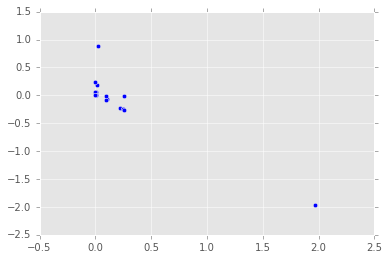

In [275]:
# exibe o scatter plot
x = result['maior perda']
y = result['resultado']
plt.scatter(x,y)

# agrupa as tabelas calculadas nos exercícios anteriores
frames = [resultados3,resultados5,resultados6,resultados7,resultados8]
result = pd.concat(frames,ignore_index=True)
result

--------------------------

### Questão 10

Mostre as volatilidades históricas dos fatores de risco Ibovespa, Jan21, USDBRL e CDS ao longo do tempo
(EMWA 0.94 e GARCH - este precisa ser calibrado).

In [379]:
def ewma94(series,window):
    
    lbda=0.94
    
    data=pd.Series(series.index)
    ativo=pd.Series(series['PX_LAST'])
    
    # vetores de retorno e retorno^2
    r=pd.Series(range(len(series)))
    r2=pd.Series(range(len(series)))
    for i in range(1,len(series)):
        r.iloc[i]=np.log(ativo[i]/ativo[i-1])
        r2.iloc[i]=r[i]**2
    
    # peso e ret^2*peso
    w=pd.Series(range(window))
    w.iloc[window-1]=(1-lbda) 
    r2w=pd.Series(range(window))
    r2w.iloc[window-1]=w[window-1]*r2[window-1]
    soma=r2w.iloc[window-1]
    for i in range(2,window):
        w.iloc[window-i]=lbda*w[window-i+1]
        r2w.iloc[window-i]=w[window-i]*r2[window-i]  
        soma=soma+r2w[window-i]
        
    # vol
    vol=pd.Series(range(len(series)-window))
    vol.iloc[0]=np.sqrt(soma)
    for i in range(1,len(vol)):
        vol.iloc[i]=np.sqrt((lbda*vol[i-1]**2)+(1-lbda)*r2[i])  
    
    colunas=['data','ativo','r','r2','w','r2w','ewma']
    resultados10=pd.DataFrame(columns=colunas)
    for i in range(len(series)):
      
        if i<window:
            resultados10.loc[i]=[data[i],ativo[i],r[i],r2[i],w[i],r2w[i],0]
        else:
            resultados10.loc[i]=[data[i],ativo[i],r[i],r2[i],0,0,vol[i-window]]
    
    return(resultados10)

In [430]:
def garch11(LRvar,vols,r2,alpha,beta,gamma):
    
    garch=pd.Series(range(len(vols)))
    garch.iloc[0]=0
    for i in range(1,len(vols)):
        garch.iloc[i]=np.sqrt(gamma*LRvar+alpha*r2.iloc[i-1]+beta*vols.iloc[i-1]**2)
    return(garch)

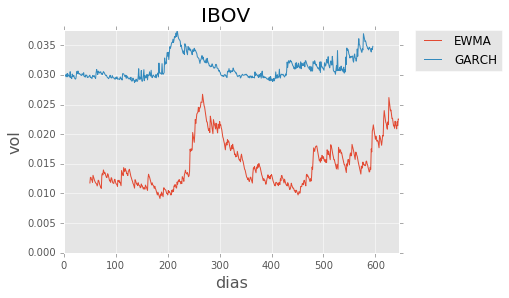

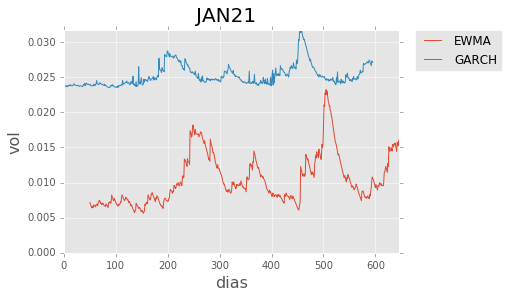

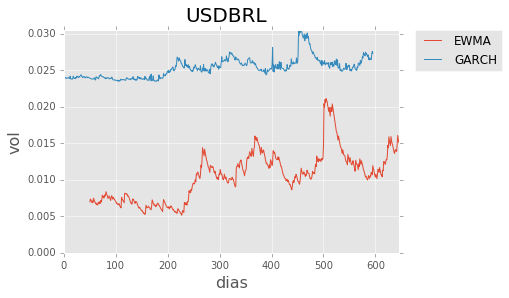

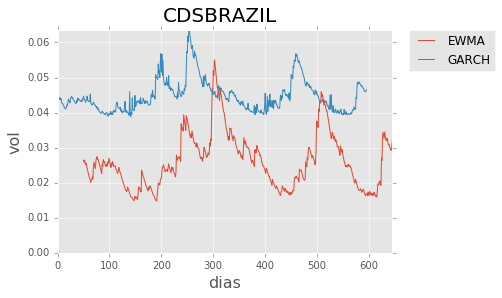

In [431]:
# tamanho da janela de observação
window=50

for i in range(4):
    if i==0:
        series=tb_IBOV
        title='IBOV'
    elif i==1:
        series=tb_DIJAN21
        title='JAN21'
    elif i==2:
        series=tb_USDBRL
        title='USDBRL'
    elif i==3:
        series=tb_CDSBRAZIL
        title='CDSBRAZIL'

    # calcula vol ewma
    vol=ewma94(series,window)
    ewma=vol['ewma'].iloc[window:]
    plt.plot(ewma,label='EWMA')

    # calcula vol GARCH - calibragem???
    r2=vol['r2'].iloc[window:]
    LRvar=np.average(ewma)
    alpha=0.05
    beta=0.90
    gamma=0.05
    garch=garch11(LRvar,ewma,r2,alpha,beta,gamma)
    plt.plot(garch,label='GARCH')

    # exibe o gráfico
    plt.suptitle(title, fontsize=20)
    plt.xlabel('dias', fontsize=16)
    plt.ylabel('vol', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.autoscale(True, 'both', True)
    plt.show()



------------

In [434]:
# PARA OBSERVAR A EVOLUÇÃO DOS PORTFOLIOS DOS EXERCICIOS 3, 5, 6, 7 e 8, BASTA EXECUTAR ESTA CÉLULA COM O LABEL CORRETO. 
# EX: '3a', '3b', '3c', etc.

portifolios['3a']

,data,prazo,K,spot,fwd,ptax,r,vol,cdi,premio,delta,caixa,port
0,2015-06-30,21.0,3.1364,3.1030,3.136400,-,0.136743,0.16112,0.1364,0.057532,0.0,-0.057532,0.000000
1,2015-07-01,20.0,3.1364,3.1492,3.180819,3.1026,0.136759,0.16195,0.1364,0.081515,0.0,-0.057562,0.023954
2,2015-07-02,19.0,3.1364,3.0967,3.126829,3.1191,0.136731,0.15243,0.1364,0.047152,0.0,-0.057591,-0.010439
3,2015-07-03,18.0,3.1364,3.1341,3.163157,3.1173,0.136715,0.15010,0.1364,0.064279,0.0,-0.057620,0.006659
4,2015-07-06,17.0,3.1364,3.1376,3.164314,3.1271,0.136840,0.14202,0.1364,0.061079,0.0,-0.057649,0.003430
5,2015-07-07,16.0,3.1364,3.1863,3.211671,3.1431,0.136914,0.15350,0.1364,0.094709,0.0,-0.057679,0.037030
6,2015-07-08,15.0,3.1364,3.2353,3.259657,3.1809,0.136921,0.15923,0.1364,0.132673,0.0,-0.057708,0.074965
7,2015-07-09,14.0,3.1364,3.2130,3.251067,3.2282,0.136887,0.15930,0.1364,0.124563,0.0,-0.057737,0.066826
8,2015-07-10,13.0,3.1364,3.1599,3.179524,3.2163,0.136894,0.15640,0.1364,0.069089,0.0,-0.057766,0.011323
9,2015-07-13,12.0,3.1364,3.1344,3.153771,3.1897,0.136994,0.14915,0.1364,0.049782,0.0,-0.057796,-0.008014
